### First attempt at building a Neural Network to learn a non-linear F(s)


In [15]:
import torch
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt


print(torch.__version__)

1.9.0


# Data Preprocessing

In [22]:
df_geometric = pd.read_csv('../bricks_data/dataset_geometric.csv')
df_kitanidis = pd.read_csv('../bricks_data/dataset_kitanidis.csv')
df_kitanidis.drop('pixel_id', axis=1, inplace=True)
df_geometric.drop('pixel_id', axis=1, inplace=True)

train_df_geo, test_df_geo = train_test_split(df_geometric, test_size=0.33, random_state=44, shuffle=True)
train_df_kit, test_df_kit = train_test_split(df_kitanidis, test_size=0.33, random_state=44, shuffle=True)

In [21]:
train_df_kit.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
89136,33,108,135,14,0.018107,1.319964,3.886310,23.432305,22.669881,20.389898,103.560000,45.820000,79.306667,1.315610e-01,2.650449e-01,2.247409e+00,23.790844,23.136869,22.230731
161006,35,124,147,20,0.027707,1.291452,4.266571,23.534226,22.664447,20.069928,90.000000,90.000000,90.000000,2.144951e+08,6.823467e+08,2.257909e+09,23.459292,23.163053,22.008386
86817,26,82,116,15,0.147090,1.324597,5.368878,23.549151,22.722929,20.304141,188.973333,81.126667,160.739333,1.058678e-01,2.296210e-01,2.123827e+00,24.115970,23.479475,22.420954
116131,11,73,71,7,0.022910,1.476976,4.209666,23.492786,22.685325,20.136689,121.533333,53.413333,128.116667,1.165547e-01,2.448748e-01,2.796967e+00,23.913834,23.310549,22.329167
34538,12,59,68,8,0.010726,1.667206,4.654831,23.515421,22.689333,19.506456,149.774994,96.747853,140.954691,1.897221e-01,4.977593e-01,3.323957e+00,23.723508,22.956473,22.234153


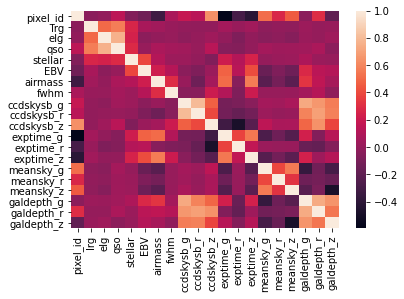

In [17]:
corrMatrix = df_kitanidis.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()


# Neural Network

### Defining The Dataset Class Inheriting from Torch.dataset to be able to use a dataloader for training

In [27]:
class DensitySurvey(Dataset):
    def __init__(self, df, galaxy_type, scaler_in=None, scaler_out=None):
        self.data = df
        # Extracting Targets and Input
        if galaxy_type == "LRG":
            self.target = self.data['lrg'].to_numpy(copy=True)
        if galaxy_type == "ELG":
            self.target = self.data['elg'].to_numpy(copy=True)
        if galaxy_type == "QSO":
            self.target = self.data['qso'].to_numpy(copy=True)
        self.input = self.data.drop(columns=['lrg','elg','qso']).to_numpy(copy=True)

        # Scaling, when scaler is passed (test-set) use the existing scaler
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        if self.scaler_in is None:
            self.scaler_in = preprocessing.MinMaxScaler()
            self.scaler_out = preprocessing.MinMaxScaler()
            self.input = self.scaler_in.fit_transform(self.input)
            self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        else:
            self.input = self.scaler_in.transform(self.input)
            self.target = self.scaler_out.transform(self.target.reshape(-1, 1))


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.tensor(self.target[idx]).float()

    def __getscaler__(self):
        return self.scaler_in, self.scaler_out



### Define Models and Hyperparameters



In [97]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_vars = 17, n_output_vars=1):
        super().__init__() # call constructor of superclass
        self.linear = nn.Linear(n_input_vars, n_output_vars)

    def forward(self, x):
        return self.linear(x)


device = 'cpu'
model = LinearRegression().to(device)



In [33]:
class Net(nn.Module):
    def __init__(self, n_feature = 16, n_hidden = 10, n_output = 1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feature,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = self.predict(out)
        return out

device = 'cpu'




In [36]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100 #very low, but computational power not sufficient for more iterations
batch = 1024
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['LRG', 'ELG', 'QSO']

### Kitanidis

In [ ]:
for gal in galaxy_types:

    model = Net().to(device)

    print("GALAXY TYPE: ", gal)
    print()
    traindata = DensitySurvey(train_df_kit, gal)
    scaler_in, scaler_out = traindata.__getscaler__()
    testdata = DensitySurvey(test_df_kit, gal, scaler_in, scaler_out)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0

        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle = True)

        for i, batch_no in enumerate(trainloader, 0):

            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            inputs = batch_no[0].to(device)
            labels = batch_no[1].to(device)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()

            #Predict outputs (forward pass)
            predictions =  model(inputs)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Backpropagation
            loss.backward()

            #Perform one step of gradient descent
            optimiser.step()

            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()
        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")


    model.eval()
    y_pred = np.array([])
    testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=False)


    for batch_no in testloader:

        #Split dataloader
        inputs = batch_no[0].to(device)
        labels = batch_no[1].to(device)

        #Forward pass through the trained network
        outputs = model(inputs)

        #Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, outputs.detach().numpy())

    y_gold = testdata.target



    print(f"Neural Net R^2 for {gal} :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Neural Net MSE for {gal} :  {metrics.mean_squared_error(y_gold, y_pred)}.")


### Geometric Neural Net

In [ ]:
for gal in galaxy_types:
    model = Net().to(device)
    print("GALAXY TYPE: ", gal)
    print()
    traindata = DensitySurvey(train_df_geo, gal)
    scaler_in, scaler_out = traindata.__getscaler__()
    testdata = DensitySurvey(test_df_geo, gal, scaler_in, scaler_out)
    
    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0

        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle = True)

        for i, batch_no in enumerate(trainloader, 0):

            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            inputs = batch_no[0].to(device)
            labels = batch_no[1].to(device)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()

            #Predict outputs (forward pass)
            predictions =  model(inputs)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Backpropagation
            loss.backward()

            #Perform one step of gradient descent
            optimiser.step()

            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()
        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")


    model.eval()
    y_pred = np.array([])
    testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=False)


    for batch_no in testloader:

        #Split dataloader
        inputs = batch_no[0].to(device)
        labels = batch_no[1].to(device)

        #Forward pass through the trained network
        outputs = model(inputs)

        #Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, outputs.detach().numpy())

    y_gold = testdata.target



    print(f"Neural Net R^2 for {gal} :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Neural Net MSE for {gal} :  {metrics.mean_squared_error(y_gold, y_pred)}.")
